# Latent Space Exploration

Load a trained autoencoder and explore the latent space by generating random latent vectors and visualizing the decoder outputs.

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

import torch
import matplotlib.pyplot as plt
import numpy as np
from model import ConvAutoencoder
from data import get_mnist_dataloaders
from utils import get_device

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

## Load Trained Model

In [7]:
# Configuration
CHECKPOINT_PATH = 'test_checkpoint_2.pth'  # Change this to your checkpoint path

# Load checkpoint
device = get_device()
checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)

# Get latent dimension from config
latent_dim = checkpoint['config']['latent_dim']
print(f"Loaded checkpoint:")
print(f"  Latent dimension: {latent_dim}")
print(f"  Trained for {checkpoint['epoch']} epochs")
print(f"  Final training loss: {checkpoint['train_losses'][-1]:.6f}")
print(f"  Device: {device}")

# Create and load model
model = ConvAutoencoder(latent_dim=latent_dim)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

print(f"\n✓ Model loaded successfully!")

Loaded checkpoint:
  Latent dimension: 16
  Trained for 10 epochs
  Final training loss: 0.009332
  Device: mps

✓ Model loaded successfully!


## Analyze Latent Space Statistics

First, let's encode some real MNIST images to understand the distribution of latent vectors.

In [8]:
# Load test data
_, _, test_loader = get_mnist_dataloaders(batch_size=128)

# Encode a batch of real images
latent_vectors = []
real_images = []

with torch.no_grad():
    for i, (images, _) in enumerate(test_loader):
        if i >= 10:  # Use first 10 batches (~1280 images)
            break
        images = images.to(device)
        latent = model.encode(images)
        latent_vectors.append(latent.cpu())
        real_images.append(images.cpu())

latent_vectors = torch.cat(latent_vectors, dim=0)
real_images = torch.cat(real_images, dim=0)

# Compute statistics
latent_mean = latent_vectors.mean(dim=0)
latent_std = latent_vectors.std(dim=0)
latent_min = latent_vectors.min(dim=0)[0]
latent_max = latent_vectors.max(dim=0)[0]

print(f"Latent space statistics (from {len(latent_vectors)} real images):")
print(f"  Mean: {latent_mean.numpy()}")
print(f"  Std:  {latent_std.numpy()}")
print(f"  Min:  {latent_min.numpy()}")
print(f"  Max:  {latent_max.numpy()}")

Latent space statistics (from 1280 real images):
  Mean: [-0.12256826 -0.33588183 -1.8873596   0.49874887 -0.42859203  0.41197532
  5.583446    2.1096838   0.42124715  1.3843809   0.62573564  2.85288
  0.16421258  0.13164127  5.196337   -0.00935841]
  Std:  [3.9168088 2.9522696 3.1344664 3.2850273 2.7150924 3.192152  3.110153
 3.9673998 3.353765  3.1103296 2.8780167 4.340577  3.4477398 4.229742
 4.434167  3.3201802]
  Min:  [-11.758227  -10.547295   -9.772013   -8.207894   -9.211372   -8.427967
  -3.833612   -9.859547   -9.118734   -7.70343    -9.42748   -10.460506
  -9.1936865  -9.775922   -7.9332614  -9.759964 ]
  Max:  [12.1321535  8.293057   7.5745344  9.348911   9.386287  12.140862
 15.768616  14.792424  12.794181  11.856032  10.368894  14.231566
 10.430038  14.385838  13.980474   8.751591 ]


/Users/johnlingi/programming/machine_learning/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


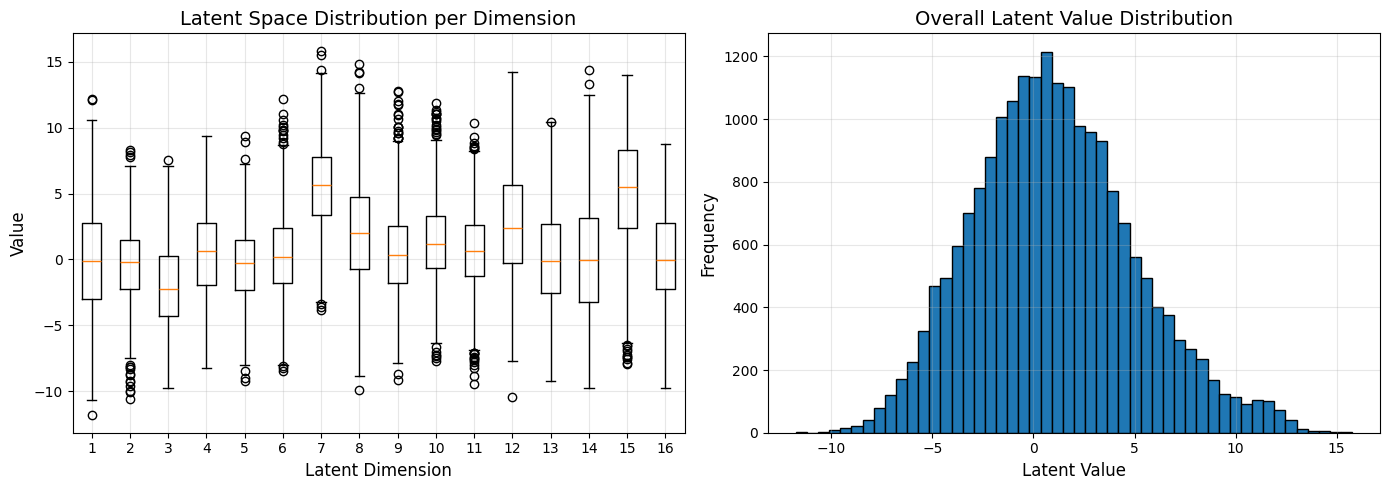

In [9]:
# Visualize latent space distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Distribution per dimension
axes[0].boxplot(latent_vectors.numpy())
axes[0].set_xlabel('Latent Dimension', fontsize=12)
axes[0].set_ylabel('Value', fontsize=12)
axes[0].set_title('Latent Space Distribution per Dimension', fontsize=14)
axes[0].grid(True, alpha=0.3)

# Plot 2: Histogram of all values
axes[1].hist(latent_vectors.numpy().flatten(), bins=50, edgecolor='black')
axes[1].set_xlabel('Latent Value', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Overall Latent Value Distribution', fontsize=14)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Generate Random Latent Vectors

Now let's generate random latent vectors and see what the decoder produces.

In [5]:
def generate_and_visualize_random(n_samples=16, distribution='normal', scale=1.0):
    """
    Generate random latent vectors and visualize decoded images.
    
    Args:
        n_samples: Number of random samples to generate
        distribution: 'normal', 'uniform', or 'learned' (based on real data stats)
        scale: Scale factor for random values
    """
    with torch.no_grad():
        if distribution == 'normal':
            # Standard normal distribution
            z = torch.randn(n_samples, latent_dim) * scale
        elif distribution == 'uniform':
            # Uniform distribution [-scale, scale]
            z = (torch.rand(n_samples, latent_dim) * 2 - 1) * scale
        elif distribution == 'learned':
            # Sample from learned distribution (mean and std from real data)
            z = torch.randn(n_samples, latent_dim) * latent_std * scale + latent_mean
        else:
            raise ValueError(f"Unknown distribution: {distribution}")
        
        z = z.to(device)
        
        # Decode
        decoded_images = model.decode(z)
        decoded_images = decoded_images.cpu()
    
    # Visualize
    n_cols = min(8, n_samples)
    n_rows = (n_samples + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 1.5, n_rows * 1.5))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(n_samples):
        row = i // n_cols
        col = i % n_cols
        axes[row, col].imshow(decoded_images[i, 0].numpy(), cmap='gray')
        axes[row, col].axis('off')
    
    # Hide unused subplots
    for i in range(n_samples, n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        axes[row, col].axis('off')
    
    plt.suptitle(f'Random Samples from {distribution.capitalize()} Distribution (scale={scale})', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    return z, decoded_images

### Standard Normal Distribution (mean=0, std=1)

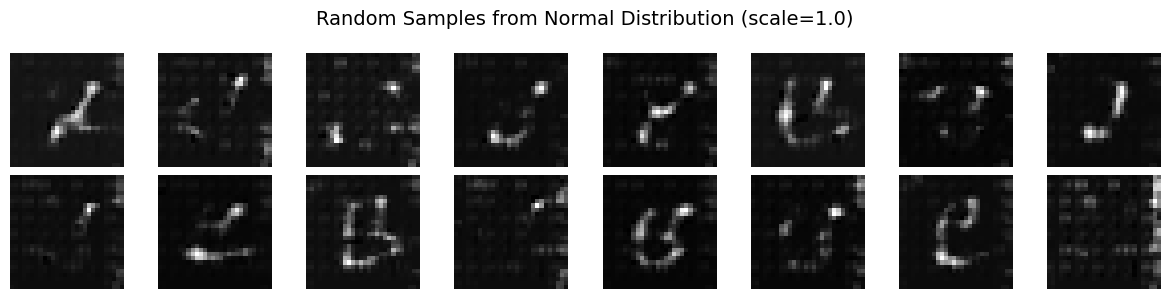

In [10]:
z_normal, images_normal = generate_and_visualize_random(
    n_samples=16, 
    distribution='normal', 
    scale=1.0
)

### Learned Distribution (from real MNIST data)

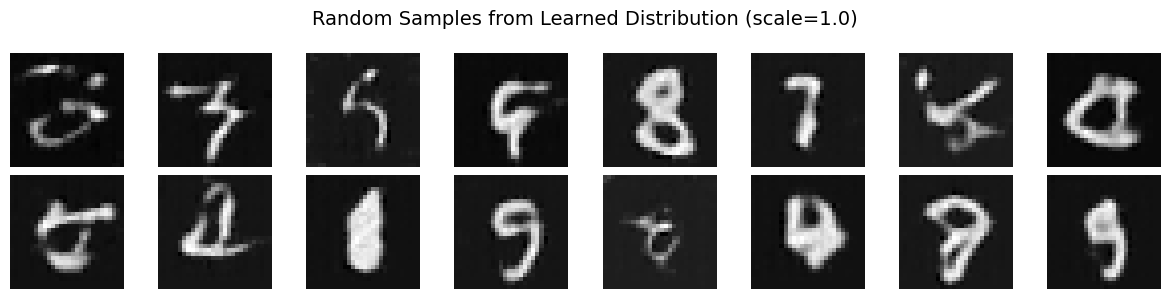

In [11]:
z_learned, images_learned = generate_and_visualize_random(
    n_samples=16, 
    distribution='learned', 
    scale=1.0
)

### Uniform Distribution

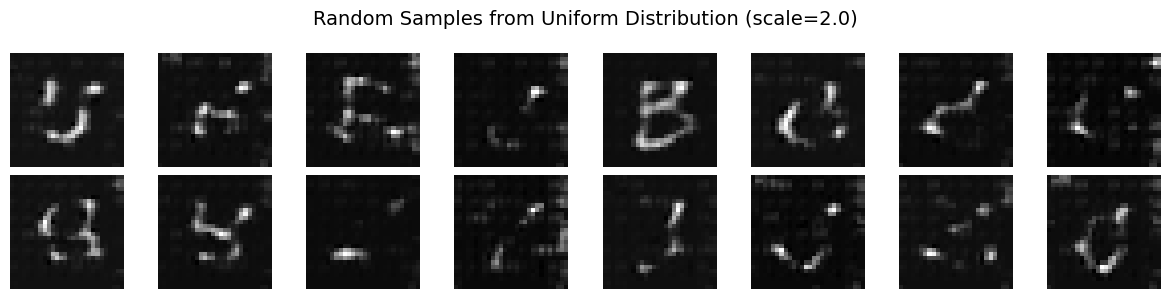

In [12]:
z_uniform, images_uniform = generate_and_visualize_random(
    n_samples=16, 
    distribution='uniform', 
    scale=2.0
)

## Custom Latent Vector Input

Manually specify a latent vector and see what it decodes to.

In [13]:
def decode_custom_vector(latent_vector):
    """
    Decode a custom latent vector and visualize the result.
    
    Args:
        latent_vector: List or array of length latent_dim
    """
    if len(latent_vector) != latent_dim:
        raise ValueError(f"Latent vector must have length {latent_dim}, got {len(latent_vector)}")
    
    z = torch.tensor([latent_vector], dtype=torch.float32).to(device)
    
    with torch.no_grad():
        decoded_image = model.decode(z)
        decoded_image = decoded_image.cpu()
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    
    # Plot latent vector
    axes[0].bar(range(latent_dim), latent_vector)
    axes[0].set_xlabel('Dimension', fontsize=12)
    axes[0].set_ylabel('Value', fontsize=12)
    axes[0].set_title('Latent Vector', fontsize=14)
    axes[0].grid(True, alpha=0.3)
    
    # Plot decoded image
    axes[1].imshow(decoded_image[0, 0].numpy(), cmap='gray')
    axes[1].axis('off')
    axes[1].set_title('Decoded Image', fontsize=14)
    
    plt.tight_layout()
    plt.show()
    
    return decoded_image

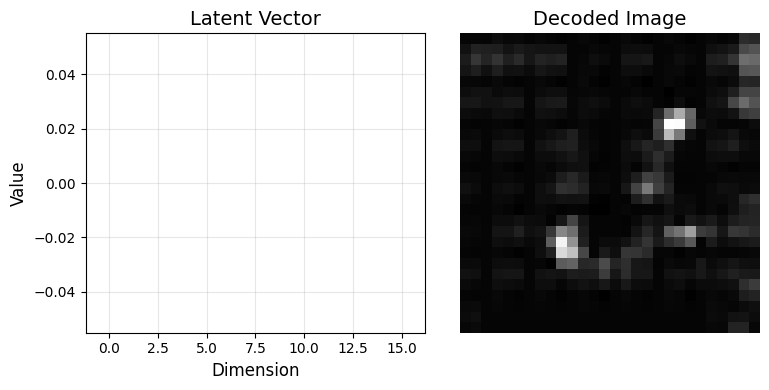

In [14]:
# Example: All zeros
custom_latent = [0.0] * latent_dim
decoded = decode_custom_vector(custom_latent)

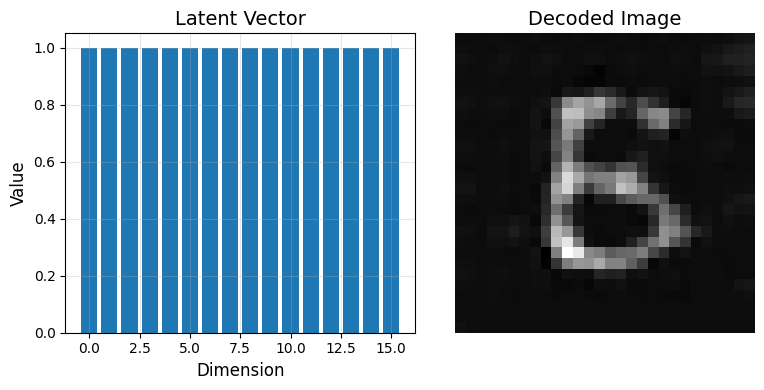

In [15]:
# Example: All ones
custom_latent = [1.0] * latent_dim
decoded = decode_custom_vector(custom_latent)

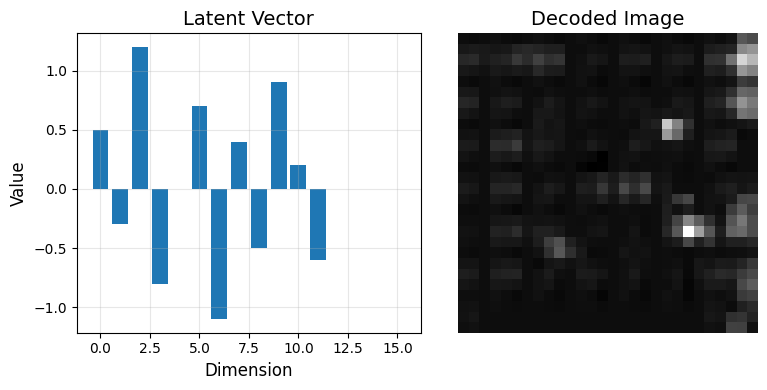

In [16]:
# Example: Random custom values
custom_latent = [0.5, -0.3, 1.2, -0.8, 0.0, 0.7, -1.1, 0.4, -0.5, 0.9, 0.2, -0.6]
if latent_dim > 12:
    custom_latent.extend([0.0] * (latent_dim - 12))
elif latent_dim < 12:
    custom_latent = custom_latent[:latent_dim]
decoded = decode_custom_vector(custom_latent)

## Explore Individual Dimensions

Vary one dimension at a time while keeping others fixed to see what each dimension controls.

In [17]:
def explore_dimension(dim_index, value_range=(-3, 3), n_steps=10, base_vector=None):
    """
    Explore what a single latent dimension controls.
    
    Args:
        dim_index: Index of the dimension to vary (0 to latent_dim-1)
        value_range: Tuple of (min_value, max_value) to sweep
        n_steps: Number of steps in the sweep
        base_vector: Base latent vector to start from (default: all zeros)
    """
    if dim_index >= latent_dim:
        raise ValueError(f"dim_index must be < {latent_dim}, got {dim_index}")
    
    if base_vector is None:
        base_vector = torch.zeros(latent_dim)
    else:
        base_vector = torch.tensor(base_vector, dtype=torch.float32)
    
    # Create a range of values for the specified dimension
    values = torch.linspace(value_range[0], value_range[1], n_steps)
    
    # Create latent vectors
    latent_vectors = base_vector.unsqueeze(0).repeat(n_steps, 1)
    latent_vectors[:, dim_index] = values
    latent_vectors = latent_vectors.to(device)
    
    # Decode
    with torch.no_grad():
        decoded_images = model.decode(latent_vectors)
        decoded_images = decoded_images.cpu()
    
    # Visualize
    fig, axes = plt.subplots(1, n_steps, figsize=(n_steps * 1.5, 2))
    
    for i in range(n_steps):
        axes[i].imshow(decoded_images[i, 0].numpy(), cmap='gray')
        axes[i].set_title(f'{values[i]:.2f}', fontsize=10)
        axes[i].axis('off')
    
    plt.suptitle(f'Varying Dimension {dim_index} from {value_range[0]} to {value_range[1]}', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    return latent_vectors, decoded_images

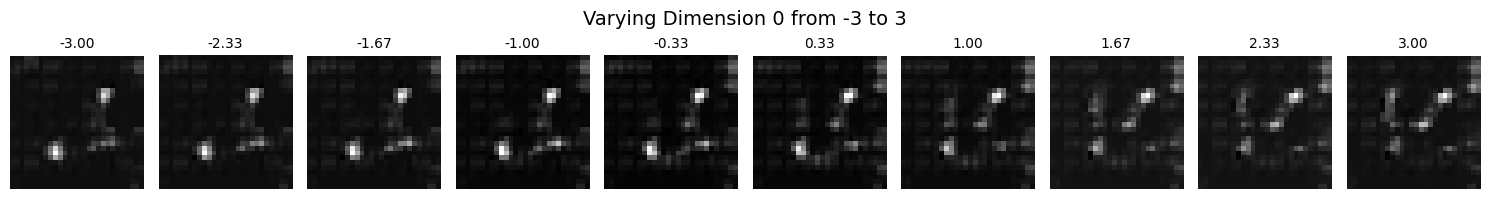

(tensor([[-3.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [-2.3333,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [-1.6667,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [-1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [-0.3333,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.3333,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [

In [18]:
# Explore dimension 0
explore_dimension(0, value_range=(-3, 3), n_steps=10)

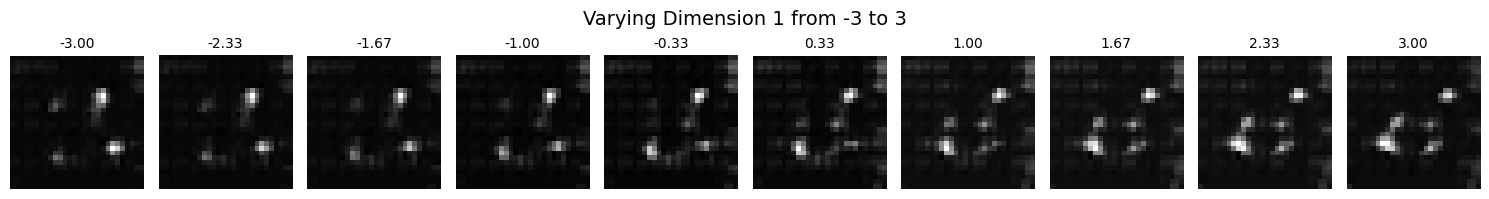

(tensor([[ 0.0000, -3.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000, -2.3333,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000, -1.6667,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000, -1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000, -0.3333,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.3333,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [

In [19]:
# Explore dimension 1
explore_dimension(1, value_range=(-3, 3), n_steps=10)


Dimension 0:


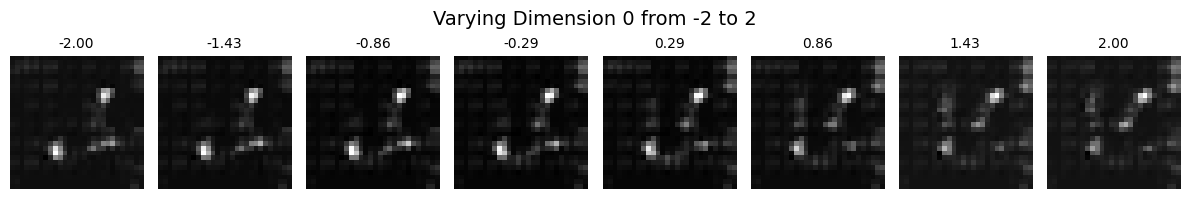


Dimension 1:


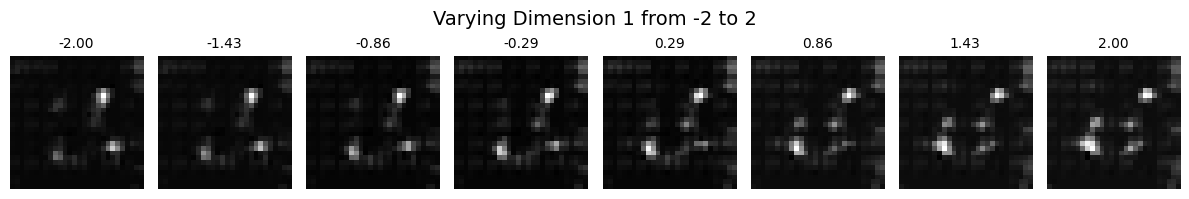


Dimension 2:


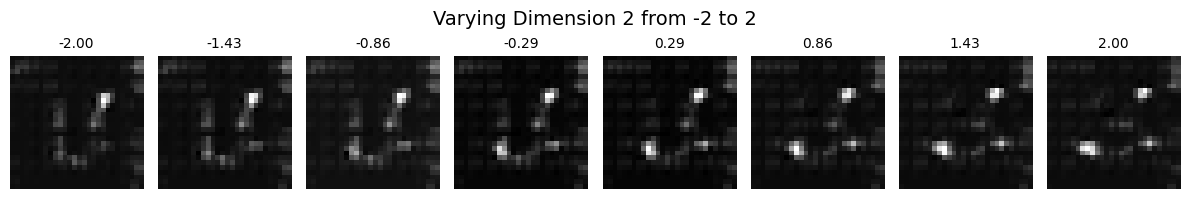


Dimension 3:


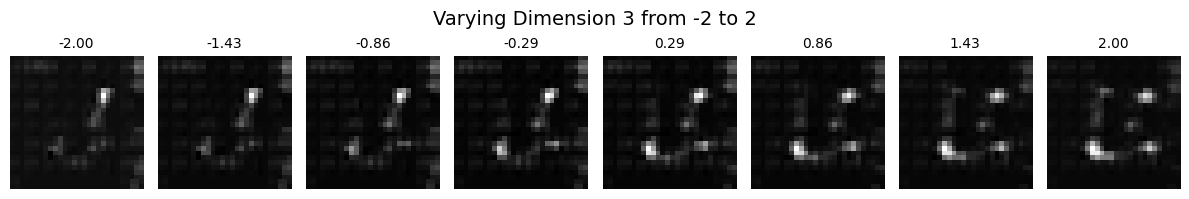


Dimension 4:


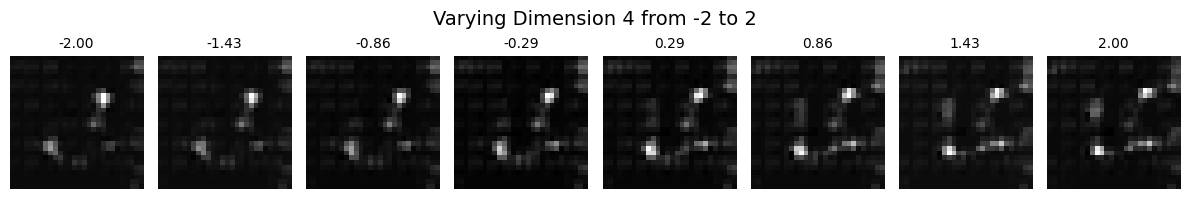


Dimension 5:


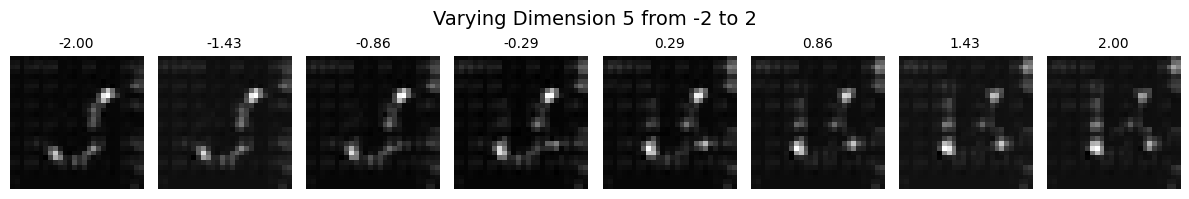


Dimension 6:


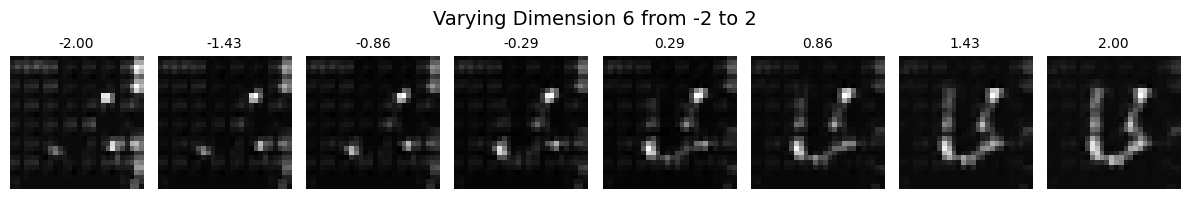


Dimension 7:


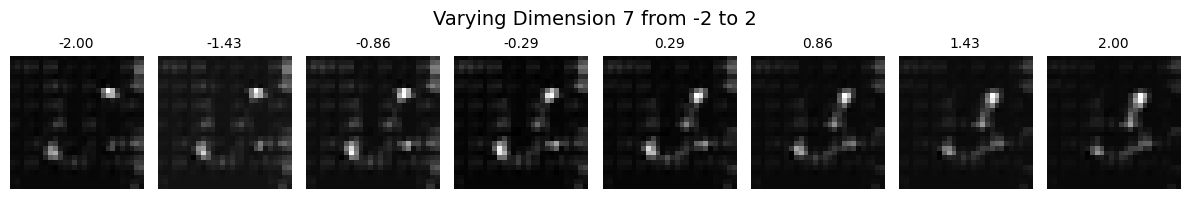

In [20]:
# Explore all dimensions at once
for dim in range(min(latent_dim, 8)):  # Limit to first 8 dimensions
    print(f"\nDimension {dim}:")
    explore_dimension(dim, value_range=(-2, 2), n_steps=8)

## Compare Real vs Generated

Compare real MNIST digits with generated images from random latent vectors.

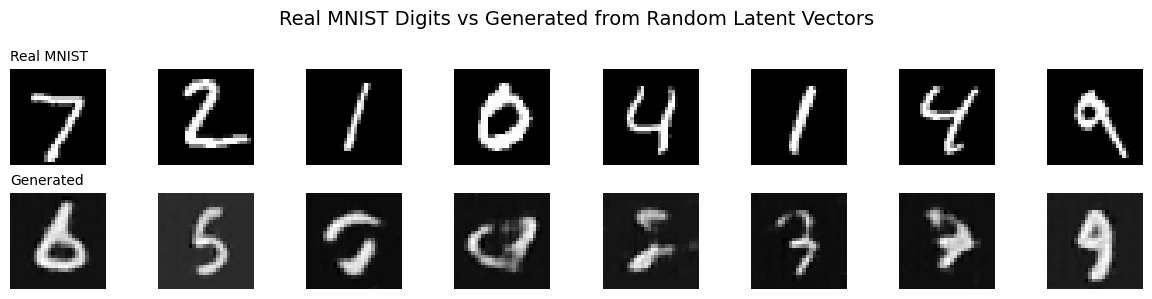

In [21]:
# Get some real images
real_batch = real_images[:8]

# Generate random samples (using learned distribution)
with torch.no_grad():
    z_random = torch.randn(8, latent_dim) * latent_std + latent_mean
    z_random = z_random.to(device)
    generated_batch = model.decode(z_random).cpu()

# Visualize
fig, axes = plt.subplots(2, 8, figsize=(12, 3))

for i in range(8):
    # Real images
    axes[0, i].imshow(real_batch[i, 0].numpy(), cmap='gray')
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_title('Real MNIST', fontsize=10, loc='left')
    
    # Generated images
    axes[1, i].imshow(generated_batch[i, 0].numpy(), cmap='gray')
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_title('Generated', fontsize=10, loc='left')

plt.suptitle('Real MNIST Digits vs Generated from Random Latent Vectors', fontsize=14)
plt.tight_layout()
plt.show()

## Latent Space Arithmetic

Try arithmetic operations on latent vectors (e.g., averaging, interpolation).

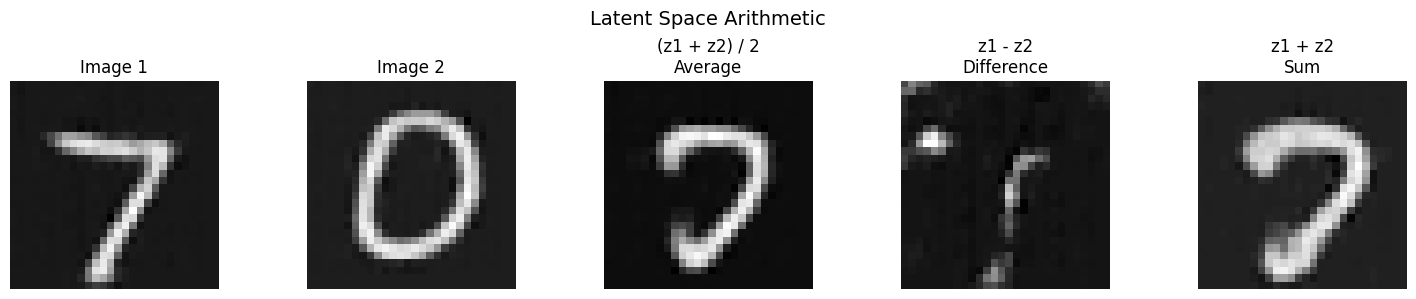

In [22]:
def latent_arithmetic_demo():
    """Demonstrate latent space arithmetic."""
    # Get two random images
    img1 = real_images[0:1].to(device)
    img2 = real_images[10:11].to(device)
    
    with torch.no_grad():
        # Encode
        z1 = model.encode(img1)
        z2 = model.encode(img2)
        
        # Arithmetic operations
        z_avg = (z1 + z2) / 2
        z_diff = z1 - z2
        z_sum = z1 + z2
        
        # Decode all
        img1_recon = model.decode(z1).cpu()
        img2_recon = model.decode(z2).cpu()
        img_avg = model.decode(z_avg).cpu()
        img_diff = model.decode(z_diff).cpu()
        img_sum = model.decode(z_sum).cpu()
    
    # Visualize
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    
    axes[0].imshow(img1_recon[0, 0].numpy(), cmap='gray')
    axes[0].set_title('Image 1', fontsize=12)
    axes[0].axis('off')
    
    axes[1].imshow(img2_recon[0, 0].numpy(), cmap='gray')
    axes[1].set_title('Image 2', fontsize=12)
    axes[1].axis('off')
    
    axes[2].imshow(img_avg[0, 0].numpy(), cmap='gray')
    axes[2].set_title('(z1 + z2) / 2\nAverage', fontsize=12)
    axes[2].axis('off')
    
    axes[3].imshow(img_diff[0, 0].numpy(), cmap='gray')
    axes[3].set_title('z1 - z2\nDifference', fontsize=12)
    axes[3].axis('off')
    
    axes[4].imshow(img_sum[0, 0].numpy(), cmap='gray')
    axes[4].set_title('z1 + z2\nSum', fontsize=12)
    axes[4].axis('off')
    
    plt.suptitle('Latent Space Arithmetic', fontsize=14)
    plt.tight_layout()
    plt.show()

latent_arithmetic_demo()